# Imports

In [ ]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

# Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tracks

In [ ]:
available_track_files = glob.glob("/content/drive/MyDrive/Colab Notebooks/racing-lines/tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['track',
 'China_track',
 'AWS_track',
 'New_York_Track',
 'Tokyo_Training_track',
 'reinvent_base',
 'canada_race',
 'reInvent2019_track',
 'Canada_Training',
 'Oval_track',
 'Mexico_track',
 'H_track',
 'Straight_track',
 'Virtual_May19_Train_track',
 'London_Loop_Train',
 'Bowtie_track']

# Race

Is loop/ring?  True


/usr/local/lib/python3.7/dist-packages/numpy/lib/twodim_base.py:146: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  m = asanyarray(m)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ary = asanyarray(ary)


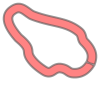

In [ ]:
# Racetrack naam
TRACK_NAME = 'reinvent_base'

# Laad de center, inner, outer waypoints
waypoints = np.load("/content/drive/MyDrive/Colab Notebooks/racing-lines/tracks/%s.npy" % TRACK_NAME)

# Verdeel de waypoint naar variabelen
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Teken de track
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

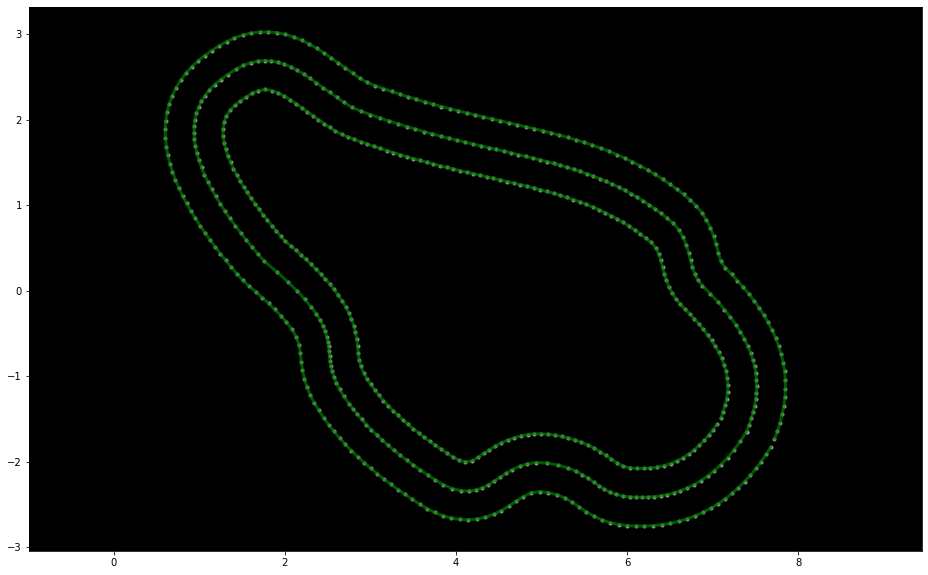

In [ ]:
# Toon de punten om de track later aan te passen
def plot_coords(ax, ob):              
    x, y = ob.xy                                 
    ax.plot(x, y, '.', color='#999999', zorder=1)                                                                                 

# Toon de racelijn
def plot_line(ax, ob):                        
    x, y = ob.xy                                 
    ax.plot(x, y, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Toon de volledige racetrack                                                              
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)


In [ ]:
# Menger kromming voor 3 punten, omgekeerde van de straal van een cirkel die door 3 punten gaat
def menger_curvature(pt1, pt2, pt3, atol=1e-3): 

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [ ]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Aantal keer de nieuwe race line punten te itereren
XI_ITERATIONS=4

def improve_race_line(old_line, inner_border, outer_border):
    # De racelijn gaan proberen verbeteren
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        # De punten van de racelijn initialiseren
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints

        # De ideale waarde tussen de 3 punten voor de racelijn te buigen
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        
        # Bereken de nieuwe positie van de racelijn
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)

        # Verbeter de ideale racelijn volgens de ingestelde parameters
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])

            if np.isclose(p_ci, target_ci):
                break
            
            # Kijk of de lijn te vlak is en hij te veel de kortste weg zal gaan zoeken en dus niet de snelste
            if p_ci < target_ci:
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)

                # Kijk of de ideale lijn niet buiten de track borders gaat
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            # Maak betere en optimale bochten voor de snelheid te gaan behouden
            else:
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # Kijk of de ideale lijn niet buiten de track borders gaat
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        
        new_line[i] = new_xi
    return new_line

In [ ]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

203
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980
Iteration 1000
Iteration 1020
Iteration 1040
Iteration 1060
Iteration 1080
Iteration 1100
Iteration 1120
Iteration 1140
Iteration 1160
Iteration 1180
Iteration 1200
Iteration 1220
Iteration 1240
Iteration 1260
Iteration 1280
Iteration 1300
Iteration 1320
Iteration 1340
Iteration 1360
Iteration 1380
It

Original centerline length: 18.45
New race line length: 16.63


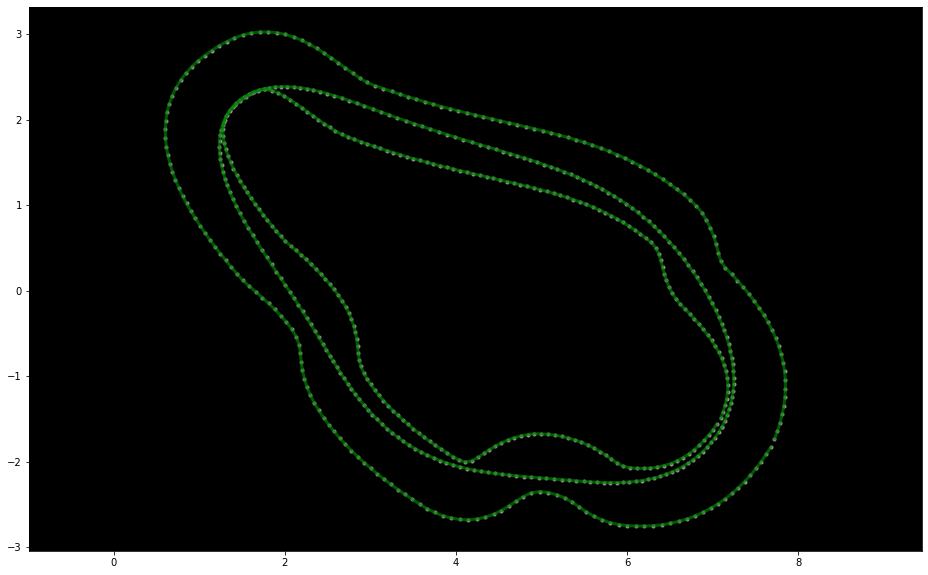

In [ ]:
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

# Save ideal race line

In [ ]:
from datetime import datetime

now = datetime.now()
prefix = '/content/drive/MyDrive/Colab Notebooks/racing-lines/tracks/%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

# Reinvent base

/usr/local/lib/python3.7/dist-packages/numpy/lib/twodim_base.py:146: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  m = asanyarray(m)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ary = asanyarray(ary)


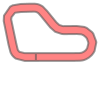

In [ ]:
# Racetrack naam
TRACK_NAME = 'reinvent_base'

# Laad de center, inner, outer waypoints
waypoints = np.load("/content/drive/MyDrive/Colab Notebooks/racing-lines/tracks/%s.npy" % TRACK_NAME)

# Verdeel de waypoint naar variabelen
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Teken de track
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

# Display the original track waypoints and lines

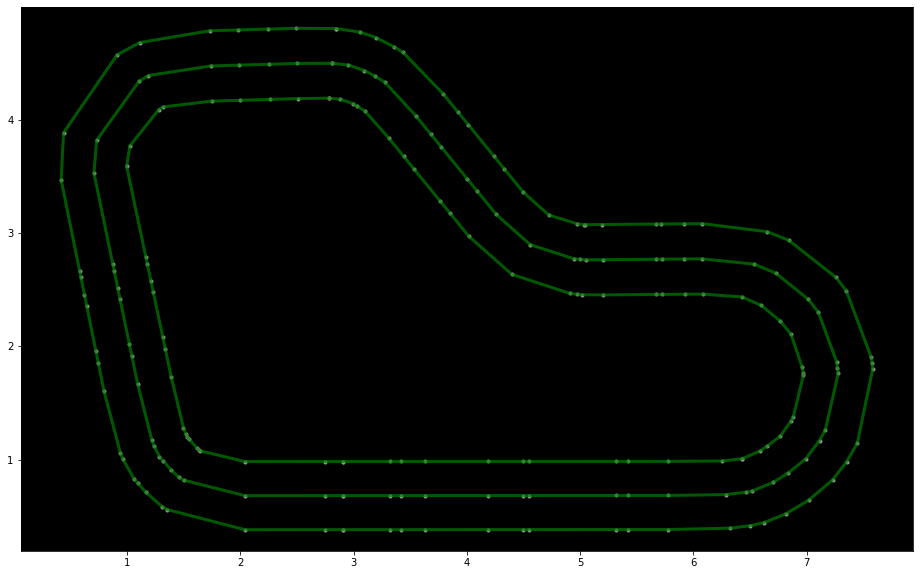

In [ ]:
# Toon de punten om de track later aan te passen
def plot_coords(ax, ob):              
    x, y = ob.xy                                 
    ax.plot(x, y, '.', color='#999999', zorder=1)                                                                                 

# Toon de racelijn
def plot_line(ax, ob):                        
    x, y = ob.xy                                 
    ax.plot(x, y, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Toon de volledige racetrack                                                              
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)


In [ ]:
# Menger kromming voor 3 punten, omgekeerde van de straal van een cirkel die door 3 punten gaat
def menger_curvature(pt1, pt2, pt3, atol=1e-3): 

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [ ]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Aantal keer de nieuwe race line punten te itereren
XI_ITERATIONS=4

def improve_race_line(old_line, inner_border, outer_border):
    # De racelijn gaan proberen verbeteren
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        # De punten van de racelijn initialiseren
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints

        # De ideale waarde tussen de 3 punten voor de racelijn te buigen
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        
        # Bereken de nieuwe positie van de racelijn
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)

        # Verbeter de ideale racelijn volgens de ingestelde parameters
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])

            if np.isclose(p_ci, target_ci):
                break
            
            # Kijk of de lijn te vlak is en hij te veel de kortste weg zal gaan zoeken en dus niet de snelste
            if p_ci < target_ci:
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)

                # Kijk of de ideale lijn niet buiten de track borders gaat
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            # Maak betere en optimale bochten voor de snelheid te gaan behouden
            else:
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # Kijk of de ideale lijn niet buiten de track borders gaat
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        
        new_line[i] = new_xi
    return new_line

# Calculate the race line!

In [ ]:
# Number of times to scan the entire race track to iterate
LINE_ITERATIONS=500

# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arccos
  # Remove the CWD from sys.path while we load stuff.


Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480


Original centerline length: 17.67
New race line length: 15.75


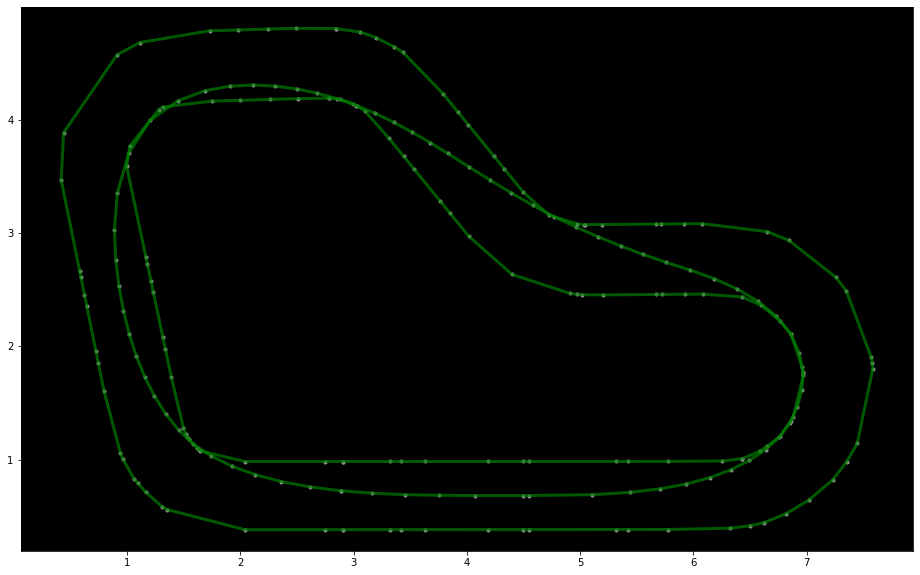

In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)